# Imports

In [0]:
import re
import numpy as np
import pandas as pd
import warnings
from __future__ import print_function
from time import time

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [0]:
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Task1

#### Functions

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [0]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

#### fetch, introspect, and standardize data

In [0]:
lfw_people = fetch_lfw_people(data_home='./gdrive/My Drive/lfw_funneled/', min_faces_per_person=70, resize=0.4)
#print(lfw_people)

In [7]:
# introspect the images arrays to find the shapes (for plotting)
# h and w of the images
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

#standardize the data
scaler = StandardScaler(copy=True)
X_standardized = scaler.fit_transform(X)

# the label to predict is the ID of the person
y = lfw_people.target
target_names = lfw_people.target_names

#n_classes = number of people with at leaset 70 images
n_classes = target_names.shape[0]
print(target_names)
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


#### split data

In [0]:
# Split into a training set and a test set using a stratified k fold
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_standardized, y, test_size=0.25, random_state=42)


#### 1.2 SVC without PCA

In [9]:
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
             }

svc = SVC(kernel='rbf', class_weight='balanced')
                   
clf = GridSearchCV(svc, param_grid, cv=5)

clf = clf.fit(X_train_s, y_train_s)

y_pred_s = clf.predict(X_test_s)

print("Best estimator %s" %clf.best_estimator_)


Best estimator SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.69      0.58        13
     Colin Powell       0.79      0.92      0.85        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.93      0.92      0.93       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.90      0.75      0.82        36

      avg / total       0.86      0.85      0.85       322

[[  9   1   3   0   0   0   0]
 [  2  55   0   2   0   1   0]
 [  4   1  18   3   0   0   1]
 [  2   6   1 135   2   0   0]
 [  0   1   0   2  20   0   2]
 [  0   3   0   1   1  10   0]
 [  1   3   1   2   2   0  27]]


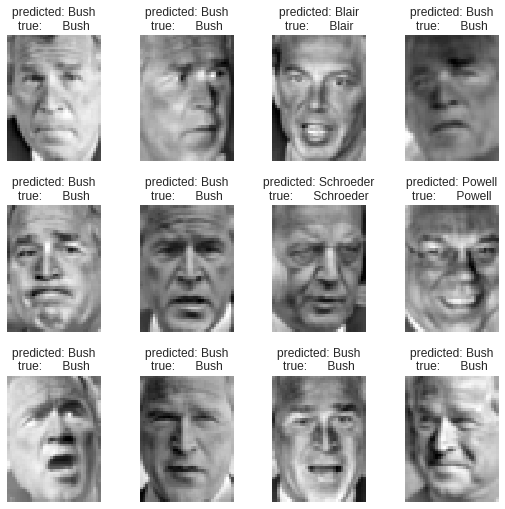

In [10]:
print(classification_report(y_test_s, y_pred_s, target_names=target_names))

print(confusion_matrix(y_test_s, y_pred_s, labels=range(n_classes)))


# plotting prediction titles and gallery (test)
prediction_titles = [ title(y_pred_s, y_test_s, target_names, i)
                     for i in range(y_pred_s.shape[0]) ]

plot_gallery(X_test_s, prediction_titles, h, w)

#### 1.3 SVC with PCA

In [11]:
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001,0.005, 0.01, 0.1],
             }

svc = SVC(kernel='rbf', class_weight='balanced')
                   
clf_pca_gs = GridSearchCV(svc, param_grid, cv=5, scoring='f1_micro')

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction 
n_components = [50, 150, 190, 300, 700]
clf_best_params = []
#performance = []
f1_scores = []

for idx, c in enumerate(n_components):
  #X_train.shape[0]=n_samples
  print("Extracting the top %d eigenfaces from %d faces"
      % (n_components[idx], X_train.shape[0]))
  
  
  pca = PCA(n_components=n_components[idx], svd_solver='randomized', 
            whiten=True).fit(X_train)

  eigenfaces = pca.components_.reshape((n_components[idx], h, w))

  #Project the input data on the eigenfaces orthonormal basis
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)

  clf_pca = clf_pca_gs.fit(X_train_pca, y_train)
  clf_best_params.append(clf_pca.best_params_)
  
  #test and evaluate
  y_pred_pca = clf_pca.predict(X_test_pca)
  f1_scores.append(f1_score(y_test, y_pred_pca, average='micro'))

  #performance.append( classification_report(
   #   y_test, y_pred_pca, target_names=target_names ) )


Extracting the top 50 eigenfaces from 966 faces
Extracting the top 150 eigenfaces from 966 faces
Extracting the top 190 eigenfaces from 966 faces
Extracting the top 300 eigenfaces from 966 faces
Extracting the top 700 eigenfaces from 966 faces


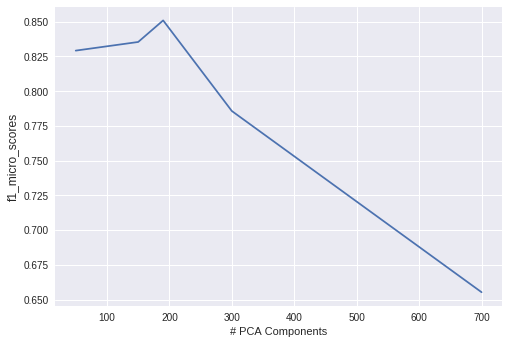

In [12]:
plt.plot(n_components, f1_scores)
plt.ylabel('f1_micro_scores', size=12) 
plt.xlabel('# PCA Components')
plt.show()

##### a) F1_score increases as #PCA decreases (from 700-150). 
##### b) However going below 150 dimensions, the f1_score decreases. 
##### The justification for the first part (a) (inverse relation) is already available in point#4. Additionally, the selected PCA's are the top most variant, therefore, naturally, decreasing the PCA's #, improves the score since the less variant features are less representitive of the data either way.  

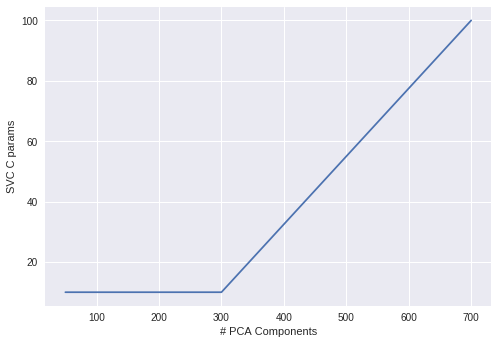

In [13]:
c_params = [b['C'] for b in clf_best_params]
plt.plot(n_components, c_params)
plt.ylabel('SVC C params') 
plt.xlabel('# PCA Components')
plt.show()

#### 1.5 Best Classifier

In [14]:
best_params = clf_best_params[1] 
print("Params of Classifier With Highest f1 Score:%s" %best_params)

Params of Classifier With Highest f1 Score:{'C': 10, 'gamma': 0.0005}


In [0]:
components = 150
svc_best = SVC(kernel='rbf', class_weight='balanced', C=1, gamma=0.005)
pca_best = PCA(n_components=components, svd_solver='randomized', 
               whiten=True).fit(X_train)
eigenfaces_best = pca_best.components_.reshape((components, h, w))

X_train_pca_best = pca_best.transform(X_train)
X_test_pca_best = pca_best.transform(X_test)

clf_pca_best = svc_best.fit(X_train_pca_best, y_train)


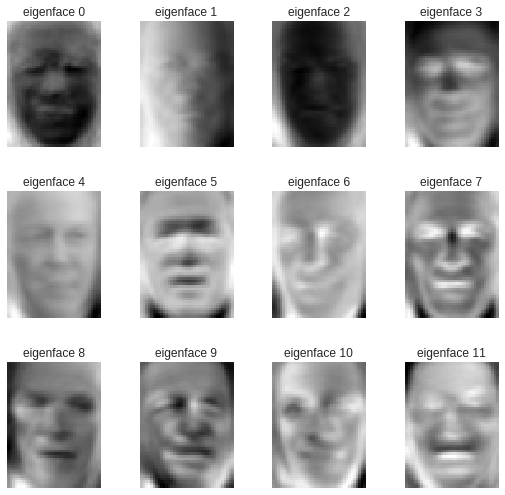

In [16]:
y_pred_best = clf_pca_best.predict(X_test_pca_best)

# plotting eigen faces of best_classifier
prediction_titles = [ title(y_pred_best, y_test, target_names, i)
                     for i in range(y_pred_best.shape[0]) ]

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_best.shape[0])]
plot_gallery(eigenfaces_best, eigenface_titles, h, w)

#### 1.6 Unfunneled LFW

In [0]:
uf_lfw_people = fetch_lfw_people(funneled=False, data_home='./gdrive/My Drive/lfw_unfunneled/', min_faces_per_person=70, resize=0.4)

In [18]:
uf_n_samples, h, w = uf_lfw_people.images.shape

X_uf = uf_lfw_people.data
uf_n_features = X_uf.shape[1]

#standardize the data
scaler = StandardScaler(copy=True)
X_uf_standardized = scaler.fit_transform(X_uf)

# the label to predict is the ID of the person
y_uf = uf_lfw_people.target
uf_target_names = uf_lfw_people.target_names

#n_classes = number of people with at leaset 70 images
uf_n_classes = uf_target_names.shape[0]
print(uf_target_names)
print("Total dataset size:")
print("n_samples: %d" % uf_n_samples)
print("n_features: %d" % uf_n_features)
print("n_classes: %d" % uf_n_classes)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
X_train_uf, X_test_uf, y_train_uf, y_test_uf = train_test_split(
    X_uf, y_uf, test_size=0.25, random_state=42)

In [0]:
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
             }

svc = SVC(kernel='rbf', class_weight='balanced')
                   
clf = GridSearchCV(svc, param_grid, cv=5, scoring='f1_micro')

n_components = [50, 150, 190, 300, 700]
clf_best_params_uf = []
f1_scores_uf = []

for idx, c in enumerate(n_components):
  pca_uf = PCA(n_components=n_components[idx], svd_solver='randomized', 
               whiten=True).fit(X_train_uf)

  eigenfaces_uf = pca_uf.components_.reshape((n_components[idx], h, w))

  X_train_pca_uf = pca_uf.transform(X_train_uf)
  X_test_pca_uf = pca_uf.transform(X_test_uf)

  clf_pca_uf = clf.fit(X_train_pca_uf, y_train_uf)
  clf_best_params_uf.append(clf_pca_uf.best_params_)
  
  y_pred_pca_uf = clf.predict(X_test_pca_uf)
  f1_scores.append(f1_score(y_test_uf, y_pred_pca_uf, average='micro'))



In [21]:
print("Best Classifier Params for Unfunneled DS: %s" %clf_best_params_uf[1])

Best Classifier Params for Unfunneled DS: {'C': 1, 'gamma': 0.005}


In [0]:
#best classifier with pca for unfunneled
components_uf = 150
svc_best_uf = SVC(kernel='rbf', class_weight='balanced', C=1, gamma=0.005)
pca_best_uf = PCA(n_components=components_uf, svd_solver='randomized', 
               whiten=True).fit(X_train_uf)
eigenfaces_best_uf = pca_best_uf.components_.reshape((components_uf, h, w))

X_train_pca_best_uf = pca_best_uf.transform(X_train_uf)
X_test_pca_best_uf = pca_best_uf.transform(X_test_uf)

clf_pca_best_uf = svc_best_uf.fit(X_train_pca_best_uf, y_train_uf)


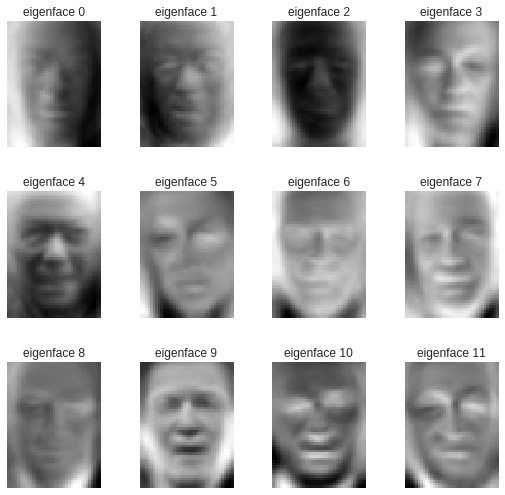

In [23]:
y_pred_best_uf = clf_pca_best_uf.predict(X_test_pca_best_uf)

target_names_uf = uf_lfw_people.target_names
# plotting eigen faces of best_classifier
prediction_titles = [ title(y_pred_best_uf, y_test_uf, target_names_uf, i)
                     for i in range(y_pred_best_uf.shape[0]) ]

eigenface_titles_uf = ["eigenface %d" % i for i in range(eigenfaces_best_uf.shape[0])]
plot_gallery(eigenfaces_best_uf, eigenface_titles_uf, h, w)

#### 1.7 Other than luminance, the only difference noted (very obvious for eigenface 5) is that that the unfunneled is a little bit rotated anti-clockwise.


#### 1.8 Timing Best SVM with PCA Classifier with Funneled Dataset

In [35]:
t0 = time()
clf_pca_best = svc_best.fit(X_train_pca_best, y_train)
print("fitting with GPU in %0.3fs" % (time() - t0)) #0.387

fitting with GPU in 0.387s


In [0]:
t0 = time()
clf_pca_best = svc_best.fit(X_train_pca_best, y_train)
print("fitting with TPU in %0.3fs" % (time() - t0)) #0.494

##### TIME FOR TRAINING FUNNELED DS WITH SVC WITH PCA AND BEST PARAMS (in seconds):
###### using TPU: 0.494
###### using GPU: 0.387
###### using CPU: 4.82

### Task 2

In [0]:
#read data set
xtrain = pd.read_csv('./gdrive/My Drive/14cancer/14cancer_xtrain.csv') 
xtest = pd.read_csv('./gdrive/My Drive/14cancer/14cancer_xtest.csv')
ytrain = pd.read_csv('./gdrive/My Drive/14cancer/14cancer_ytrain.csv')
ytest = pd.read_csv('./gdrive/My Drive/14cancer/14cancer_ytest.csv')

In [0]:
#xtrain
#print(xtest)
#print(ytrain)
#print(ytest)
xtrain = ( np.array(xtrain.values) ).transpose()
xtest = ( np.array(xtest.values) ).transpose()
ytrain = ( np.array(ytrain.values) ).transpose()
ytest = ( np.array(ytest.values) ).transpose()

cancer_train_samples = xtrain.shape[0]
cancer_test_samples = xtest.shape[0]
cancer_total_samples = cancer_train_samples + cancer_test_samples

In [0]:
cancer_param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],               
             }

cancer_svc = SVC(kernel='rbf', class_weight='balanced')

cancer_clf = GridSearchCV(cancer_svc, cancer_param_grid, cv=5, scoring='f1_micro')

#initially tried the suggested range with step=5
cancer_n_comp = np.arange(94, 121, 2)

In [0]:
cancer_clf_best_params = []
cancer_f1_train = []
cancer_f1_test = []

for idx, c in enumerate(cancer_n_comp):  
  cancer_pca = PCA(n_components=cancer_n_comp[idx], svd_solver='randomized', 
            whiten=True).fit(xtrain)

  #Project the input data on the eigenvectors orthonormal basis
  xtrain_pca = cancer_pca.transform(xtrain)
  xtest_pca = cancer_pca.transform(xtest)

  cancer_clf_pca = cancer_clf.fit(xtrain_pca, ytrain)
  #get best params after fitting with gs
  cancer_clf_best_params.append(cancer_clf_pca.best_params_)
  
  #test and evaluate
  cancer_ypred_train = cancer_clf_pca.predict(xtrain_pca)
  cancer_f1_train.append(f1_score(ytrain, cancer_ypred_train, average='micro'))
  
  cancer_ypred_test = cancer_clf_pca.predict(xtest_pca)
  cancer_f1_test.append(f1_score(ytest, cancer_ypred_test, average='micro'))

In [108]:
cancer_f1_train

[0.9375,
 0.9305555555555556,
 0.9722222222222222,
 1.0,
 0.9722222222222222,
 0.9375,
 1.0,
 0.9722222222222222,
 0.9722222222222222,
 0.9722222222222222,
 0.9861111111111112,
 1.0,
 0.9791666666666666,
 0.9583333333333334]

In [109]:
cancer_f1_test

[0.5740740740740741,
 0.5740740740740741,
 0.6481481481481481,
 0.6666666666666666,
 0.6296296296296297,
 0.5740740740740741,
 0.6666666666666666,
 0.7222222222222222,
 0.6851851851851852,
 0.6666666666666666,
 0.6481481481481481,
 0.5740740740740741,
 0.5925925925925926,
 0.6111111111111112]

#### 2.3 The data is overfitted in the training process. This is observed from the train vs test scores. The train scores are ~100%, while the test scores are relatively low (~60%-~70%).

##### f1 score is used because the data is not balanced; only 8 samples belong to the positive class (has cancer) in the train set for instance.

In [107]:
cancer_clf_best_params

[{'C': 100, 'gamma': 0.0001},
 {'C': 10, 'gamma': 0.001},
 {'C': 100, 'gamma': 0.0005},
 {'C': 1000.0, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 10, 'gamma': 0.001},
 {'C': 1000.0, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 1000.0, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0005},
 {'C': 100, 'gamma': 0.0001}]

In [0]:
cancer_best_ncomp = 108
cancer_svc_best = SVC(kernel='rbf', class_weight='balanced', C=100, gamma=0.0005)
cancer_pca_best = PCA(n_components=cancer_best_ncomp, svd_solver='randomized', 
               whiten=True).fit(xtrain)

xtrain_pca_best = cancer_pca_best.transform(xtrain)
xtest_pca_best = cancer_pca_best.transform(xtest)

clf_pca_best = cancer_svc_best.fit(xtrain_pca_best, ytrain)

### BONUS

In [0]:
#n_classes = len(set(ytrain.ravel()))
cl = AgglomerativeClustering(n_clusters=14)
cl = cl.fit(xtrain)

In [145]:
cl_pred = cl.labels_
print(homogeneity_score(cl_pred, ytrain.ravel() ) )

0.5739263007986839
